# Week 7: Robust model fitting using RANSAC

These exercises will introduce you to robust model fitting. You will implement straight line finding \
using RANSAC

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def test_points(n_in, n_out):
    a = (np.random.rand(n_in)-.5)*10
    b = np.vstack((a, a*.5+np.random.randn(n_in)*.25))
    points = np.hstack((b, 2*np.random.randn(2, n_out)))
    return np.random.permutation(points.T).T


In [4]:
n_in = 500
n_out = 50
points = test_points(n_in, n_out)

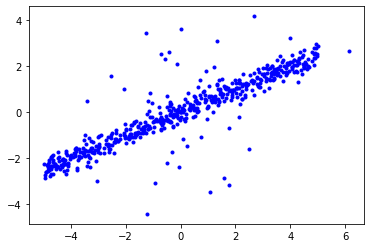

In [5]:
plt.plot(points[0, :], points[1, :], ".b")

#### Exercise 7.1

Given two points in homogenous coordinates, estimate a line, also in homogenous coordinates.

In [6]:
# https://math.stackexchange.com/questions/290315/equation-of-a-line-in-homogenous-coordinates-given-2-points-in-affine-coordinate

def est_line(p1, p2):
    return np.cross(p1, p2)

In [7]:
p1 = points[:, 0]
p2 = points[:, 1]
p1 = np.hstack((p1, 1))
p2 = np.hstack((p2, 1))

C = est_line(p1, p2)
# C[0]*x + C[1]*y + C[2] = 0
# a*x + b*y + c = 0

a = C[0]
b = C[1]
c = C[2]
a, b, c


(2.0039512627601934, -3.507039336312395, 0.48665399343582266)

#### 7.2 

Make a function that determines if a given 2D point is an inlier or an outlier with respect to a \
given line. The threshold should be supplied as parameter to this function, such that it can easily \
be tuned later

In [8]:
p2

array([-0.37505852, -0.07554663,  1.        ])

In [9]:
def is_inliner(point, line, threshold):
    line=line.copy()
    point=point.copy()
    # First we normalize a^2 + b^2 = 1
    a = line[0]
    b = line[1]
    scale = np.sqrt(a**2 + b**2)
    line/= scale

    # Then we can calculate distance to line:
    dist = np.abs(line.T@point)
    return dist<threshold

print(is_inliner(p1, C, 1))
print(is_inliner(p2, C, 1))
print(is_inliner(np.array([5, 5, 1]), C, 1))
# NB! Both the homogenous points and the line is all scale invariant!
print(is_inliner(p1*15, C, 1))
print(is_inliner(p2, C*15, 1))

True
True
False
True
True


#### 7.3 

Make a function that calculates the consensus, i.e. the number of inliers, for a line with respect to
a set of points


In [32]:
def consensus(line, points, threshold=1):
    '''
    Line is a homogenous line.
    Points is set of inhomogenous points.
    TODO: get rid of for loop.
    '''
    no = 0
    for i in range(len(points[0])):
        point = np.array([points[0, i],
                          points[1, i],
                          1])
        if is_inliner(point, line, threshold=threshold):
            no+=1
    return no

#### 7.4

Make a function that randomly draws two of n 2D points.

In [11]:
def drawTwo(points):
    indexes = np.random.choice(len(points[0]), 2)
    return points[:, indexes]

In [12]:
p1, p2 = drawTwo(points)

#### 7.5

Assemble the functions made above to a working RANSAC algorithm for estimating lines. Set the \
number of iterations and the threshold manually.


```Python
C[0]*x + C[1]*y + C[2] = 0
a*x + b*y + c = 0
y = 1/b(-a*x - c)
```

In [33]:
def RANSAC_simple(points, threshold=1, iterations=500):
    best_inliers = 0
    best_line = None
    for i in range(iterations):
        # Draw two random points
        p1, p2 = drawTwo(points)
        p1 = np.hstack((p1, 1))
        p2 = np.hstack((p2, 1))
        # Estimate the line
        line = est_line(p1, p2)
        # Find no. inliers
        no_inliers = consensus(line, points, threshold=threshold)
        if no_inliers>best_inliers:
            best_line = line.copy()
            best_inliers = no_inliers
    return best_line

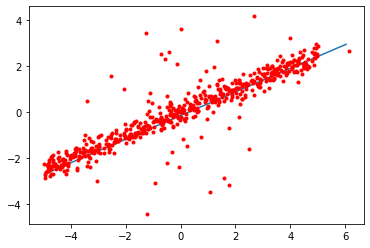

In [36]:
best_line = RANSAC_simple(points, threshold=0.2, iterations=500)

a = best_line[0]
b = best_line[1]
c = best_line[2]

xs = np.arange(points[0,:].min(), points[0,:].max())
plt.plot(xs, 1/b*(-a*xs - c))
plt.plot(points[0, :], points[1, :], ".r")

**Threshold** If it is too big, then the "best line" will just be any line pointing in more or less the right direction. If it is too small then any line will be equally bad and the results are random.

Using 1/4 the thickness of the shape of the points seems to be nice.

#### 7.7 

Add the final step to your implementation, where you fit a new line to all inliers of the best \
line. The total least squares fit of a straight line to a set of points is given by the first principal \
component of them.

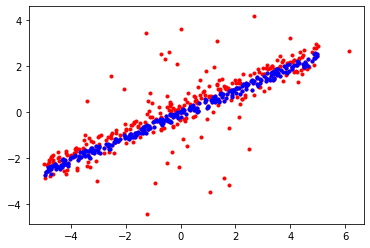

In [43]:
best_line = RANSAC_simple(points, threshold=0.2, iterations=500)

best_i = []
for i in range(len(points[0])):
    p = np.hstack((points[:, i], 1))
    if is_inliner(p, best_line, threshold=0.2):
        best_i.append(i)
best_points = points[:, best_i]

plt.plot(points[0, :], points[1, :], ".r")
plt.plot(best_points[0, :], best_points[1, :], ".b")

In [66]:
def pca_line(x): #assumes x is a (2 x n) array of points
    d = np.cov(x)[:, 0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(-(l@x.mean(1)))
    return l


def RANSAC_fit(points, threshold=1, iterations=500):
    best_inliers = 0
    best_line = None
    for i in range(iterations):
        # Draw two random points
        p1, p2 = drawTwo(points)
        p1 = np.hstack((p1, 1))
        p2 = np.hstack((p2, 1))
        # Estimate the line
        line = est_line(p1, p2)
        # Find no. inliers
        no_inliers = consensus(line, points, threshold=threshold)
        if no_inliers>best_inliers:
            best_line = line.copy()
            best_inliers = no_inliers
    
    # We now have the best line. Extract inliners and fit.
    best_i = []
    for i in range(len(points[0])):
        p = np.hstack((points[:, i], 1))
        if is_inliner(p, best_line, threshold=threshold):
            best_i.append(i)
    best_points = points[:, best_i]
    
    fit_line = pca_line(best_points)
    return fit_line, best_points

In [124]:
fit_line, best_points = RANSAC_fit(points, threshold=0.3, iterations=500)

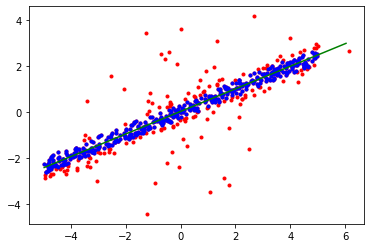

In [125]:
xs = np.arange(points[0,:].min(), points[0,:].max())
a = fit_line[0]
b = fit_line[1]
c = fit_line[2]

plt.plot(points[0, :], points[1, :], ".r")
plt.plot(best_points[0, :], best_points[1, :], ".b")
plt.plot(xs, 1/b*(-a*xs - c), "g")

### 7.8

Implement the stopping criteria for RANSAC as described on the slides. Use p = 0.99.


- $\epsilon$ is relative share of outliers in data.
- n is the datapoints in one sample: DoF of the model we want to fit.
- p is the probability of having at least one sample with no outlayers

>    P(one sample is of only inliers) = (1-$\epsilon$)^nn \
>    P(one sample has any outlayers) = 1 - (1-$\epsilon$)^n \
>    P(each of N samples all has one outlayer) = (1 - (1-$\epsilon$)^n)^N \
>    P(at least one sample has no outlayers) = 1 - ((1 - (1-$\epsilon$)^n)^N) = p \

- Run the algorithm until N samples has been tested: $N = \frac{log(1-p)}{log(1-(1-\epsilon)^n)}$ => p is guaranteed.

- Often, you do not know epsilon. Then use eps_hat = 1 - s/m as an estimation, where s is the most no. of inliers found so far, and m is total no. of points. This will be an upper limit of epsilon and guarantees that we get at least p accuracy.

In [138]:
def RANSAC_epsilon(points, threshold, p=0.99):
    best_inliers = 0
    best_line = None
    
    m = len(points[0])
    iteration = 0 # Current iteration
    N_hat = 1000 # Iterations needed to achieve p
    epsilon_hat = 1
    while iteration<N_hat:
        # Draw two random points
        p1, p2 = drawTwo(points)
        p1 = np.hstack((p1, 1))
        p2 = np.hstack((p2, 1))
        # Estimate the line
        line = est_line(p1, p2)
        # Find no. inliers
        no_inliers = consensus(line, points, threshold=threshold)
        if no_inliers>best_inliers:
            best_line = line.copy()
            best_inliers = no_inliers
            # Should we stop?
            epsilon_hat = 1 - best_inliers/m
            N_hat = np.log(1 - p) / np.log(1 - (1 - epsilon_hat)**2)
            print("eps_hat:", epsilon_hat, " ==> \tN-hat", N_hat, end="\n")

        iteration += 1
    
    # We now have the best line. Extract inliners and fit.
    best_i = []
    for i in range(len(points[0])):
        p = np.hstack((points[:, i], 1))
        if is_inliner(p, best_line, threshold=threshold):
            best_i.append(i)
    best_points = points[:, best_i]
    
    fit_line = pca_line(best_points)
    print("Ran for %i iterations" % iteration)
    return fit_line, best_points

In [147]:
fit_line, best_points = RANSAC_epsilon(points, threshold=0.9, p=0.99)

eps_hat: 0.9836363636363636  ==> 	N-hat 17196.018068448517
eps_hat: 0.9527272727272728  ==> 	N-hat 2058.442090755805
eps_hat: 0.9436363636363636  ==> 	N-hat 1447.2945093702087
eps_hat: 0.9272727272727272  ==> 	N-hat 868.3603679821165
eps_hat: 0.9145454545454546  ==> 	N-hat 628.3256484901526
eps_hat: 0.7054545454545454  ==> 	N-hat 50.743828721038106
Ran for 79 iterations


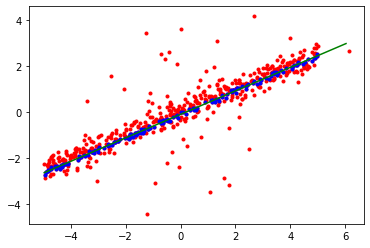

In [148]:
xs = np.arange(points[0,:].min(), points[0,:].max())
a = fit_line[0]
b = fit_line[1]
c = fit_line[2]

plt.plot(points[0, :], points[1, :], ".r")
plt.plot(best_points[0, :], best_points[1, :], ".b")
plt.plot(xs, 1/b*(-a*xs - c), "g")